Extracting BDF parameters from /Users/stageacomeback/Desktop/Gerard Lee/PolyU SPEED RA/EEG Brain Signal Analysis/Self Testing (gtec Sample Dataset)/BCI Core Recorder/UnicornBCICoreRecorder_19_12_2025_10_53_28.bdf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6035  =      0.000 ...    24.140 secs...
<Info | 8 non-empty values
 bads: []
 ch_names: EXG 1, EXG 2, EXG 3, EXG 4, EXG 5, EXG 6, EXG 7, EXG 8, Status
 chs: 8 EEG, 1 Stimulus
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: 2025-12-19 10:53:53 UTC
 nchan: 9
 projs: []
 sfreq: 250.0 Hz
 subject_info: <subject_info | his_id: X>
>
Channel names: ['EXG 1', 'EXG 2', 'EXG 3', 'EXG 4', 'EXG 5', 'EXG 6', 'EXG 7', 'EXG 8', 'Status']
Sampling frequency: 250.0 Hz
Detected EEG channels: ['EXG 1', 'EXG 2', 'EXG 3', 'EXG 4', 'EXG 5', 'EXG 6', 'EXG 7', 'EXG 8']
Events from annotations (count): 0
Event ID map: {}
Using stim channel for events: Status
Finding events on: Status


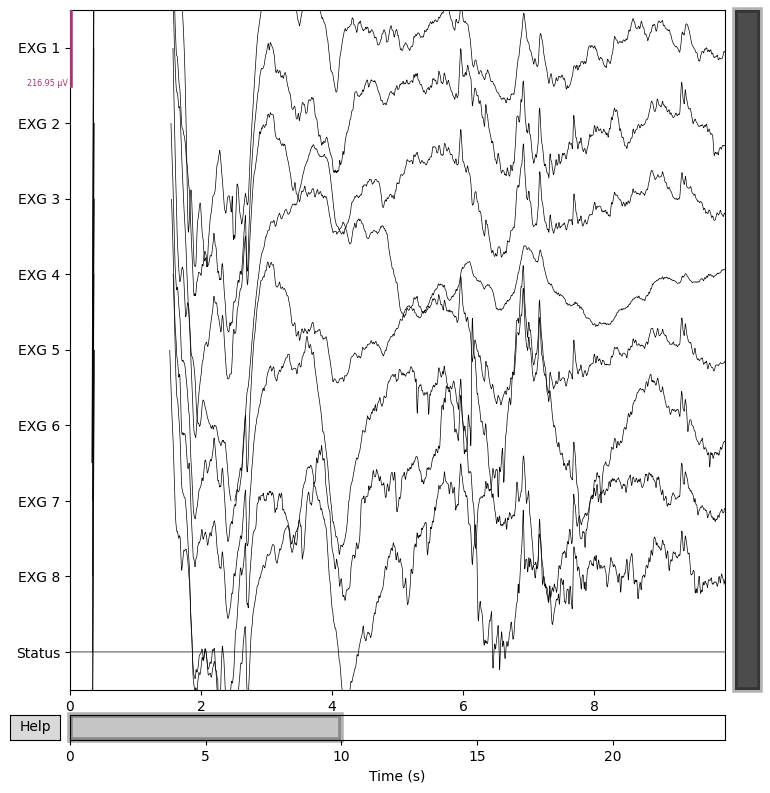

    time         EXG 1         EXG 2         EXG 3         EXG 4  \
0  0.000  -3267.619209  -3005.352795  -3129.807301  -3986.129402   
1  0.004 -12914.184506 -11829.928269 -12334.809442 -15738.050088   
2  0.008 -24687.974136 -22490.708380 -23487.006038 -30054.270032   
3  0.012 -33807.538975 -30655.156413 -32050.405863 -41138.177582   
4  0.016 -39356.368146 -35662.089924 -37283.860879 -47918.927545   

          EXG 5         EXG 6         EXG 7         EXG 8  
0  -2698.168319  -2708.646817  -3720.447643  -2236.274018  
1 -10620.466508 -10663.971941 -14648.733416  -8802.107501  
2 -20190.570962 -20278.422253 -27860.008351 -16732.237740  
3 -27518.956513 -27643.285849 -37984.221457 -22801.755238  
4 -32012.550951 -32156.621346 -44186.633479 -26520.799191  


In [10]:
import numpy as np
import pandas as pd
import mne
import matplotlib.pyplot as plt
from pathlib import Path

# Path to your BDF file
file_path = Path('/Users/stageacomeback/Desktop/Gerard Lee/PolyU SPEED RA/EEG Brain Signal Analysis/Self Testing (gtec Sample Dataset)/BCI Core Recorder/UnicornBCICoreRecorder_19_12_2025_10_53_28.bdf')

# -------------------------------------------------------------------
# 1) Load BDF (MNE handles scaling; data returned in Volts)
# -------------------------------------------------------------------
raw = mne.io.read_raw_bdf(str(file_path), preload=True)  # preload=True loads data into memory

# -------------------------------------------------------------------
# 2) Inspect info, sampling rate, channel names
# -------------------------------------------------------------------
print(raw.info)
print(f"Channel names: {raw.ch_names}")
sfreq = raw.info['sfreq']
print(f"Sampling frequency: {sfreq} Hz")
times = raw.times  # numpy array in seconds

# -------------------------------------------------------------------
# 3) Pick EEG channels and get data (no manual unit_factor needed)
# -------------------------------------------------------------------
eeg_picks = mne.pick_types(raw.info, eeg=True, stim=False, misc=False)
eeg_ch_names = [raw.ch_names[p] for p in eeg_picks]
print("Detected EEG channels:", eeg_ch_names)

if len(eeg_ch_names) == 0:
    raise RuntimeError("No EEG channels detected. Check channel names in raw.ch_names.")

# Get EEG data as numpy array (shape: n_channels x n_samples), in Volts
eeg_data_volts = raw.get_data(picks=eeg_picks)

# If you prefer microvolts for further processing or saving:
eeg_data_uV = eeg_data_volts * 1e6

# -------------------------------------------------------------------
# 4) Montage (optional) — attach standard 10-20 positions when possible
# -------------------------------------------------------------------
try:
    montage = mne.channels.make_standard_montage('standard_1020')
    raw.set_montage(montage, on_missing='ignore')
except Exception as e:
    print("Montage assignment skipped:", e)

# -------------------------------------------------------------------
# 5) Events / triggers
#    Prefer annotations (many BDF recordings include annotations).
#    Fallback: search for a stim/status channel and extract events.
# -------------------------------------------------------------------
# Convert annotations (if present) to events
events_from_annot, event_id_map = mne.events_from_annotations(raw)
print("Events from annotations (count):", len(events_from_annot))
print("Event ID map:", event_id_map)

events = events_from_annot
if events.size == 0:
    # Try to extract from a stim channel (common names: 'Status', 'STI 014', 'Trigger', etc.)
    stim_picks = mne.pick_types(raw.info, stim=True)
    if len(stim_picks) > 0:
        stim_ch = raw.ch_names[stim_picks[0]]
        print("Using stim channel for events:", stim_ch)
        # uint_cast=True often helps with BioSemi packed bit status channels
        events = mne.find_events(raw, stim_channel=stim_ch, shortest_event=1, uint_cast=True)
    else:
        print("No events found (no annotations and no stim channel).")

# -------------------------------------------------------------------
# 6) Plot and convert to pandas DataFrame
# -------------------------------------------------------------------
# Interactive MNE plot (requires a GUI backend)
raw.plot(scalings='auto', title='Raw EEG (BDF)', show=True)

# Convert to DataFrame; index = time (seconds), values in Volts
# You can pass a list of channel names (picks) to keep only EEG channels
eeg_df = raw.to_data_frame(picks=eeg_ch_names)

# If you want microvolts in DataFrame:
eeg_df_uV = eeg_df * 1e6

print(eeg_df.head())

# Optional: save EEG channels to CSV (in microvolts)
# eeg_df_uV.to_csv('eeg_from_bdf_uV.csv', index_label='time_s')

# -------------------------------------------------------------------
# Optional preprocessing examples (uncomment when needed)
# -------------------------------------------------------------------
# raw.set_eeg_reference('average', projection=False)  # re-reference to average
# raw.filter(l_freq=1.0, h_freq=40.0)                 # bandpass filter 1-40 Hz
# raw.resample(250)                                   # downsample to 250 Hz
# -------------------------------------------------------------------

In [11]:
# ------------------ CELL: imports, helpers & PSD wrapper ------------------
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mne
from scipy.stats import kurtosis
from scipy.signal import spectrogram

print("Python:", sys.version.splitlines()[0])
print("MNE:", mne.__version__)
print("NumPy:", np.__version__)

# Ensure raw exists
if 'raw' not in globals():
    raise RuntimeError("`raw` is not defined. Run the earlier cell that reads the file first.")

# Output folder
out_dir = "eeg_analysis_outputs"
os.makedirs(out_dir, exist_ok=True)

# Choose an n_fft that is <= n_times and a power-of-two
def choose_n_fft(raw_obj, target=2048):
    n_times = int(raw_obj.n_times)
    if n_times <= 0:
        return 256
    cap = min(target, n_times)
    p = int(np.floor(np.log2(max(1, cap))))
    return max(64, 2 ** p)

# PSD wrapper: prefer mne.time_frequency.psd_array_welch (works with MNE 1.11.0).
# Fallbacks: try mne.time_frequency.psd_welch, then scipy.signal.welch per-channel.
try:
    from mne.time_frequency import psd_array_welch

    def compute_psd(raw_obj, picks=None, fmin=None, fmax=None, n_fft=2048, n_overlap=0, n_jobs=1, verbose=False):
        picks = (mne.pick_types(raw_obj.info, eeg=True, meg=False, stim=False)
                 if picks is None else picks)
        data = raw_obj.get_data(picks=picks)        # shape (n_ch, n_times)
        sfreq = raw_obj.info['sfreq']
        psds, freqs = psd_array_welch(data, sfreq=sfreq, fmin=fmin, fmax=fmax,
                                      n_fft=n_fft, n_overlap=n_overlap,
                                      n_jobs=n_jobs, verbose=verbose)
        # psds: V^2/Hz, shape (n_ch, n_freqs)
        return psds, freqs

except Exception:
    try:
        # older style API (may exist)
        from mne.time_frequency import psd_welch as _psd_welch

        def compute_psd(raw_obj, picks=None, fmin=None, fmax=None, n_fft=2048, n_overlap=0, n_jobs=1, verbose=False):
            picks = (mne.pick_types(raw_obj.info, eeg=True, meg=False, stim=False)
                     if picks is None else picks)
            psds, freqs = _psd_welch(raw_obj, picks=picks, fmin=fmin, fmax=fmax,
                                     n_fft=n_fft, n_overlap=n_overlap, n_jobs=n_jobs, verbose=verbose)
            return psds, freqs

    except Exception:
        # final fallback: per-channel scipy.signal.welch
        from scipy.signal import welch

        def compute_psd(raw_obj, picks=None, fmin=None, fmax=None, n_fft=2048, n_overlap=0, n_jobs=1, verbose=False):
            picks = (mne.pick_types(raw_obj.info, eeg=True, meg=False, stim=False)
                     if picks is None else picks)
            data = raw_obj.get_data(picks=picks)
            sfreq = raw_obj.info['sfreq']
            nperseg = int(n_fft)
            noverlap = int(n_overlap)
            psds_list = []
            freqs = None
            for ch in range(data.shape[0]):
                f, Pxx = welch(data[ch], fs=sfreq, nperseg=nperseg, noverlap=noverlap)
                if (fmin is not None) or (fmax is not None):
                    mask = np.ones_like(f, dtype=bool)
                    if fmin is not None:
                        mask &= (f >= fmin)
                    if fmax is not None:
                        mask &= (f <= fmax)
                    f_sel = f[mask]
                    Pxx_sel = Pxx[mask]
                else:
                    f_sel = f
                    Pxx_sel = Pxx
                psds_list.append(Pxx_sel)
                freqs = f_sel
            psds = np.vstack(psds_list)
            return psds, freqs

print("PSD wrapper ready (using psd_array_welch when available).")

Python: 3.13.1 (v3.13.1:06714517797, Dec  3 2024, 14:00:22) [Clang 15.0.0 (clang-1500.3.9.4)]
MNE: 1.11.0
NumPy: 2.2.6
PSD wrapper ready (using psd_array_welch when available).


In [12]:
# ------------------ CELL: per-channel stats & candidate bads ------------------
import numpy as np
import pandas as pd
from scipy.stats import kurtosis

# Ensure raw exists
if 'raw' not in globals():
    raise RuntimeError("`raw` is not defined. Run the earlier cell that reads the file first.")

# Load all data into memory if not already (safe for moderate recordings)
data_V = raw.get_data()         # Volts
data_uV = data_V * 1e6         # µV

ch_names = raw.ch_names
stats = pd.DataFrame(index=ch_names)

# Use top-level numpy functions (compatible with NumPy 2.x)
stats['mean_uV'] = np.mean(data_uV, axis=1)
stats['std_uV']  = np.std(data_uV, axis=1)
stats['rms_uV']  = np.sqrt(np.mean(data_uV ** 2, axis=1))
stats['ptp_uV']  = np.ptp(data_uV, axis=1)        # <- fixed here
stats['kurtosis'] = kurtosis(data_uV, axis=1, fisher=False, bias=False)

# Robust outlier detection: median & MAD on RMS
med = stats['rms_uV'].median()
mad = np.median(np.abs(stats['rms_uV'] - med)) or 1.0
stats['rms_robust_z'] = 0.6745 * (stats['rms_uV'] - med) / mad

# Show top channels by RMS
display(stats.sort_values('rms_uV', ascending=False).head(12))

# Suggest potential noisy channels (tunable threshold)
threshold = 3.5
potential_bads = stats.index[np.abs(stats['rms_robust_z']) > threshold].tolist()
print(f"Potential noisy channels (robust z > {threshold}):", potential_bads)

print("\nTo mark suggested bads (manual):\n    raw.info['bads'].extend(potential_bads)\nThen inspect with raw.plot(order='bads first').")

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/scipy/stats/_stats_py.py:1469: RuntimeWarning: invalid value encountered in divide
  nval = 1.0/(n-2)/(n-3) * ((n**2-1.0)*m4/m2**2.0 - 3*(n-1)**2.0)


,mean_uV,std_uV,rms_uV,ptp_uV,kurtosis,rms_robust_z
EXG 4,-1.218471,3289.889686,3289.889912,60143.677005,94.927000,2.239213
EXG 7,0.679386,3041.516413,3041.516489,55583.814119,94.847924,1.571864
EXG 1,-0.208853,2700.678309,2700.678317,49356.654248,94.870276,0.656074
EXG 3,-0.165687,2565.058364,2565.058370,46866.705827,94.770695,0.291680
EXG 2,0.710587,2456.501124,2456.501227,44880.529933,94.700690,0.000000
EXG 6,0.497014,2215.591670,2215.591725,40459.909466,94.616991,-0.647294
EXG 5,0.064602,2205.466246,2205.466247,40281.953828,94.697734,-0.674500
EXG 8,0.450157,1827.207898,1827.207954,33352.555832,94.695865,-1.690833
Status,0.000000,0.000000,0.000000,0.000000,NaN,-6.600316


Potential noisy channels (robust z > 3.5): ['Status']

To mark suggested bads (manual):
    raw.info['bads'].extend(potential_bads)
Then inspect with raw.plot(order='bads first').


In [13]:
# ------------------ CELL: mains detection + notch + bandpass ------------------
# EEG picks (fallback heuristics if none flagged)
eeg_picks = mne.pick_types(raw.info, eeg=True, meg=False, stim=False)
if len(eeg_picks) == 0:
    # fallback: choose all non-stim channels
    eeg_picks = [i for i, ch in enumerate(raw.ch_names) if 'status' not in ch.lower() and 'stim' not in ch.lower()]
print("EEG picks used:", [raw.ch_names[p] for p in eeg_picks])

# Choose safe n_fft
n_fft = choose_n_fft(raw, target=4096)
print("Using n_fft =", n_fft, "for mains detection (n_times =", raw.n_times, ")")

# PSD in 40–60 Hz to detect mains
try:
    psds_tmp, freqs_tmp = compute_psd(raw, picks=eeg_picks, fmin=40.0, fmax=60.0, n_fft=n_fft, n_overlap=0, n_jobs=1)
    psd_mean = psds_tmp.mean(axis=0)
    peak_idx = int(np.argmax(psd_mean))
    peak_freq = float(freqs_tmp[peak_idx])
    print(f"Peak in 40–60 Hz band at ~{peak_freq:.2f} Hz")
    peak_power = psd_mean[peak_idx]
    median_power = np.median(psd_mean)
except Exception as exc:
    peak_freq = None
    print("Mains PSD detection failed:", exc)
    peak_power = 0
    median_power = 0

# Decide mains candidates
line_freqs = []
if peak_freq is not None and peak_power > 6 * (median_power + 1e-30):
    if 48 <= peak_freq <= 52:
        line_freqs = [50.0, 100.0]
    elif 58 <= peak_freq <= 62:
        line_freqs = [60.0, 120.0]
    else:
        line_freqs = [round(peak_freq, 1), round(2 * peak_freq, 1)]
print("Detected mains candidates:", line_freqs if line_freqs else "none (or not strong)")

# Make a working copy and filter
raw_clean = raw.copy().load_data()

# Apply notch if mains detected
if line_freqs:
    print("Applying notch filter at:", line_freqs)
    raw_clean.notch_filter(freqs=line_freqs, picks=eeg_picks, fir_design='firwin')

# Apply recommended band-pass (1–40 Hz)
l_freq, h_freq = 1.0, 40.0
print(f"Applying band-pass filter {l_freq}–{h_freq} Hz on the copy (raw_clean).")
raw_clean.filter(l_freq=l_freq, h_freq=h_freq, picks=eeg_picks, fir_design='firwin')

print("Filtering complete — use `raw_clean` for downstream steps (original `raw` preserved).")

EEG picks used: ['EXG 1', 'EXG 2', 'EXG 3', 'EXG 4', 'EXG 5', 'EXG 6', 'EXG 7', 'EXG 8']
Using n_fft = 4096 for mains detection (n_times = 6036 )
Peak in 40–60 Hz band at ~40.34 Hz
Detected mains candidates: [40.3, 80.7]
Applying notch filter at: [40.3, 80.7]
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)



Applying band-pass filter 1.0–40.0 Hz on the copy (raw_clean).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 s)

Filtering complete — use `raw_clean` for downstream steps (original `raw` preserved).


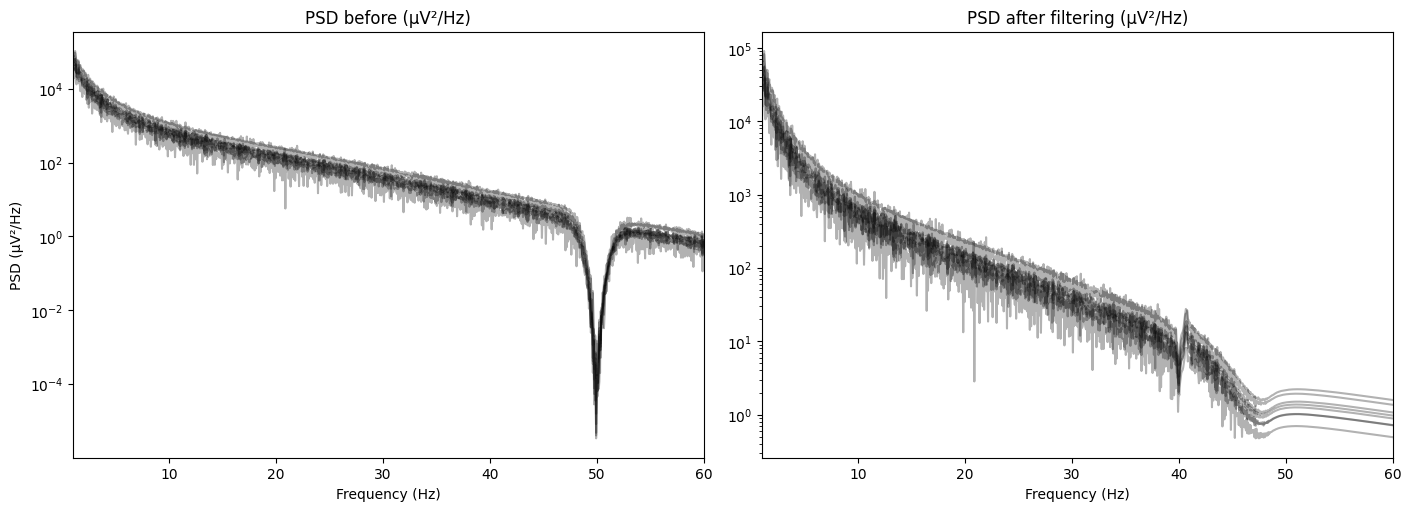

Saved PSD figure to: eeg_analysis_outputs/psd_before_after_uV.png


In [14]:
# ------------------ CELL: PSD before / after (µV^2/Hz) ------------------
plot_picks = eeg_picks  # change to a subset if you have many channels

n_fft_plot = choose_n_fft(raw, target=4096)
psd_before, freqs = compute_psd(raw, picks=plot_picks, fmin=1.0, fmax=60.0, n_fft=n_fft_plot, n_overlap=0, n_jobs=1)
psd_after, _ = compute_psd(raw_clean, picks=plot_picks, fmin=1.0, fmax=60.0, n_fft=n_fft_plot, n_overlap=0, n_jobs=1)

# Convert PSD from V^2/Hz -> µV^2/Hz
factor = 1e12
psd_before_uV = psd_before * factor
psd_after_uV  = psd_after  * factor

fig, axes = plt.subplots(1, 2, figsize=(14, 5), constrained_layout=True)
axes[0].set_title("PSD before (µV²/Hz)")
for ii in range(psd_before_uV.shape[0]):
    axes[0].semilogy(freqs, psd_before_uV[ii], color='k', alpha=0.3)
axes[0].set_xlim(1, 60)
axes[0].set_xlabel("Frequency (Hz)")
axes[0].set_ylabel("PSD (µV²/Hz)")

axes[1].set_title("PSD after filtering (µV²/Hz)")
for ii in range(psd_after_uV.shape[0]):
    axes[1].semilogy(freqs, psd_after_uV[ii], color='k', alpha=0.3)
axes[1].set_xlim(1, 60)
axes[1].set_xlabel("Frequency (Hz)")

fig_path = os.path.join(out_dir, "psd_before_after_uV.png")
fig.savefig(fig_path, dpi=150)
plt.show()
print("Saved PSD figure to:", fig_path)

In [15]:
# ------------------ CELL: band-power calculation (µV^2 & relative %) ------------------
bands = {
    'delta': (1.0, 4.0),
    'theta': (4.0, 8.0),
    'alpha': (8.0, 13.0),
    'beta':  (13.0, 30.0),
    'gamma': (30.0, 40.0),
}

n_fft_bp = choose_n_fft(raw_clean, target=4096)
psds, freqs = compute_psd(raw_clean, picks=eeg_picks, fmin=1.0, fmax=40.0, n_fft=n_fft_bp, n_overlap=0, n_jobs=1)

band_power = pd.DataFrame(index=[raw_clean.ch_names[p] for p in eeg_picks])
total_power = np.trapz(psds, freqs, axis=1)   # V^2 in 1-40 Hz
band_power['total_V2'] = total_power
band_power['total_uV2'] = band_power['total_V2'] * 1e12

for bname, (fmin, fmax) in bands.items():
    idx = np.logical_and(freqs >= fmin, freqs <= fmax)
    p = np.trapz(psds[:, idx], freqs[idx], axis=1)
    band_power[f'{bname}_V2'] = p
    band_power[f'{bname}_uV2'] = p * 1e12
    band_power[f'{bname}_pct'] = 100.0 * (p / band_power['total_V2'])

display(band_power.sort_values('alpha_pct', ascending=False).head(12))
csv_bands = os.path.join(out_dir, "band_power_per_channel.csv.gz")
band_power.to_csv(csv_bands, compression='gzip')
print("Saved band-power table to", csv_bands)

/var/folders/6f/twg_bwys7xb6mgr86_05x41m0000gn/T/ipykernel_3264/3367965186.py:14: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total_power = np.trapz(psds, freqs, axis=1)   # V^2 in 1-40 Hz
/var/folders/6f/twg_bwys7xb6mgr86_05x41m0000gn/T/ipykernel_3264/3367965186.py:20: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  p = np.trapz(psds[:, idx], freqs[idx], axis=1)
/var/folders/6f/twg_bwys7xb6mgr86_05x41m0000gn/T/ipykernel_3264/3367965186.py:20: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  p = np.trapz(psds[:, idx], freqs[idx], axis=1)
/var/folders/6f/twg_bwys7xb6mgr86_05x41m0000gn/T/ipykernel_3264/3367965186.py:20: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integrati

,total_V2,total_uV2,delta_V2,delta_uV2,delta_pct,theta_V2,theta_uV2,theta_pct,alpha_V2,alpha_uV2,alpha_pct,beta_V2,beta_uV2,beta_pct,gamma_V2,gamma_uV2,gamma_pct
EXG 8,2.898587e-08,28985.872885,2.183637e-08,21836.373474,75.334538,3.927244e-09,3927.244003,13.548821,1.609393e-09,1609.392532,5.552334,1.347311e-09,1347.311090,4.648165,1.175259e-10,117.525885,0.405459
EXG 6,4.234424e-08,42344.244404,3.216156e-08,32161.556320,75.952604,5.688301e-09,5688.301095,13.433469,2.228800e-09,2228.800112,5.263526,1.878344e-09,1878.343768,4.435889,1.652509e-10,165.250910,0.390256
EXG 5,4.155097e-08,41550.968739,3.159303e-08,31593.028565,76.034397,5.577187e-09,5577.186872,13.422519,2.170852e-09,2170.851710,5.224551,1.821248e-09,1821.248328,4.383167,1.604813e-10,160.481251,0.386227
EXG 7,7.893138e-08,78931.382793,5.987393e-08,59873.931184,75.855672,1.065940e-08,10659.401944,13.504644,4.119981e-09,4119.980654,5.219699,3.489903e-09,3489.903335,4.421439,3.105779e-10,310.577947,0.393478
EXG 3,5.582042e-08,55820.418491,4.245897e-08,42458.968373,76.063508,7.499083e-09,7499.082702,13.434300,2.895166e-09,2895.166007,5.186572,2.441885e-09,2441.884665,4.374537,2.167983e-10,216.798282,0.388385
EXG 4,9.059635e-08,90596.352438,6.880972e-08,68809.717831,75.951974,1.221749e-08,12217.487348,13.485628,4.697212e-09,4697.212441,5.184770,3.989044e-09,3989.044185,4.403096,3.565968e-10,356.596813,0.393611
EXG 2,5.180633e-08,51806.333054,3.950064e-08,39500.638741,76.246737,6.885977e-09,6885.977157,13.291767,2.682227e-09,2682.227170,5.177412,2.255037e-09,2255.036811,4.352821,1.995902e-10,199.590156,0.385262
EXG 1,6.207156e-08,62071.562039,4.725822e-08,47258.224008,76.135065,8.308076e-09,8308.076409,13.384674,3.193708e-09,3193.708102,5.145203,2.696804e-09,2696.804295,4.344670,2.414193e-10,241.419317,0.388937


Saved band-power table to eeg_analysis_outputs/band_power_per_channel.csv.gz


In [16]:
# ------------------ CELL: ICA (optional) ------------------
from mne.preprocessing import ICA

n_eeg = len(eeg_picks)
if n_eeg < 3:
    print("Too few EEG channels for ICA (need >= 3). Skipping ICA.")
else:
    n_components = min(8, n_eeg)  # adjust as needed
    print("Fitting ICA with n_components =", n_components, "(this may take a while)")
    ica = ICA(n_components=n_components, random_state=97, max_iter='auto')
    try:
        ica.fit(raw_clean, picks=eeg_picks)
        print("ICA fitted. Inspect with: ica.plot_components(), ica.plot_sources(raw_clean)")
    except Exception as exc:
        print("ICA failed:", exc)
        ica = None

# If you visually pick components to exclude, set components_to_remove and apply:
components_to_remove = [0, 2]
if ica is not None and components_to_remove:
    ica.exclude = components_to_remove
    raw_ica_clean = raw_clean.copy()
    ica.apply(raw_ica_clean)
else:
    raw_ica_clean = raw_clean

Fitting ICA with n_components = 8 (this may take a while)
Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components
Fitting ICA took 0.1s.
ICA fitted. Inspect with: ica.plot_components(), ica.plot_sources(raw_clean)
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


In [17]:
# ------------------ CELL: events detection & epoching ------------------
events = None
event_id = None

# 1) Try annotations (recommended)
if hasattr(raw, 'annotations') and len(raw.annotations) > 0:
    try:
        events, event_id = mne.events_from_annotations(raw)
        print("Events extracted from annotations:", events.shape, "event_id:", event_id)
    except Exception as exc:
        print("events_from_annotations failed:", exc)
        events = None

# 2) If no annotations, look for stim channel(s)
if events is None or events.size == 0:
    stim_picks = mne.pick_types(raw.info, stim=True)
    if len(stim_picks) > 0:
        stim_ch = raw.ch_names[stim_picks[0]]
        try:
            events = mne.find_events(raw, stim_channel=stim_ch, shortest_event=1, verbose=False)
            print("Events found on stim channel", stim_ch, "->", events.shape)
        except Exception as exc:
            print("mne.find_events failed on", stim_ch, ":", exc)
            events = None

# 3) Fallback: scan channels for discrete steps (analog triggers)
if (events is None or events.size == 0):
    for ch in raw.ch_names:
        if 'status' in ch.lower() or 'stim' in ch.lower() or 'trigger' in ch.lower():
            idx = raw.ch_names.index(ch)
            arr = raw.get_data(picks=[idx])[0]
            vals = np.round(arr).astype(int)
            diffs = np.diff(vals)
            edges = np.where(diffs != 0)[0] + 1
            if len(edges) > 0:
                events = np.column_stack((edges, np.zeros_like(edges, dtype=int), vals[edges]))
                print("Fallback found transitions in", ch, "->", events.shape[0], "events")
                break

if events is None or events.size == 0:
    print("No events found (annotations or stim-like channels).")
else:
    # Build event_id mapping from unique codes (if integer codes present)
    unique_codes = np.unique(events[:, 2])
    event_id = {str(int(c)): int(c) for c in unique_codes}
    print("Auto event_id mapping:", event_id)
    tmin, tmax = -0.2, 0.8
    epochs = mne.Epochs(raw_clean, events, event_id=event_id, tmin=tmin, tmax=tmax,
                        baseline=(None, 0), picks=eeg_picks, preload=True)
    print("Created epochs:", epochs)
    # Plot average (evoked) for up to first 3 codes
    shown = 0
    for k, code in enumerate(event_id):
        try:
            ev = epochs[code].average()
            ev.plot(title=f"Evoked {code}", show=True)
            shown += 1
            if shown >= 3:
                break
        except Exception:
            pass

Events found on stim channel Status -> (0, 3)
No events found (annotations or stim-like channels).


Spectrogram channel: EXG 1
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


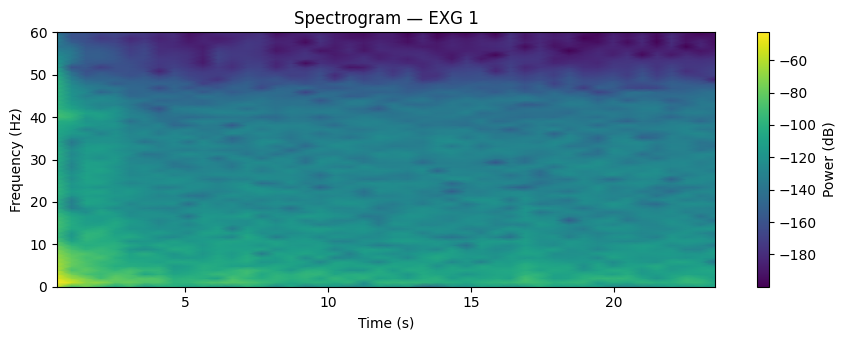

Saved spectrogram to: eeg_analysis_outputs/spectrogram_EXG_1.png
Overwriting existing file.
Writing /Users/stageacomeback/Desktop/Gerard Lee/PolyU SPEED RA/EEG Brain Signal Analysis/Self Testing (gtec Sample Dataset)/BCI Core Recorder/eeg_analysis_outputs/raw_filtered.fif
Overwriting existing file.
Closing /Users/stageacomeback/Desktop/Gerard Lee/PolyU SPEED RA/EEG Brain Signal Analysis/Self Testing (gtec Sample Dataset)/BCI Core Recorder/eeg_analysis_outputs/raw_filtered.fif
[done]
Saved filtered raw (FIF) to: eeg_analysis_outputs/raw_filtered.fif
Saved filtered timeseries (compressed) to: eeg_analysis_outputs/raw_filtered_timeseries.csv.gz size (MB): 0.4542074203491211


/var/folders/6f/twg_bwys7xb6mgr86_05x41m0000gn/T/ipykernel_3264/3232590535.py:28: RuntimeWarning: This filename (/Users/stageacomeback/Desktop/Gerard Lee/PolyU SPEED RA/EEG Brain Signal Analysis/Self Testing (gtec Sample Dataset)/BCI Core Recorder/eeg_analysis_outputs/raw_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean.save(out_fif, overwrite=True)


In [18]:
# ------------------ CELL: spectrogram & saving processed data ------------------
if len(eeg_picks) == 0:
    ch_spec = raw.ch_names[0]
else:
    ch_spec = raw.ch_names[eeg_picks[0]]
print("Spectrogram channel:", ch_spec)

sig = raw_clean.copy().pick_channels([ch_spec]).get_data()[0]  # Volts
sfreq = raw_clean.info['sfreq']

f, t, Sxx = spectrogram(sig, fs=sfreq, nperseg=256, noverlap=128, scaling='density')
plt.figure(figsize=(9, 3.5))
plt.pcolormesh(t, f, 10 * np.log10(Sxx + 1e-20), shading='gouraud', cmap='viridis')
plt.colorbar(label='Power (dB)')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.ylim(0, 60)
plt.title(f"Spectrogram — {ch_spec}")
spec_path = os.path.join(out_dir, f"spectrogram_{ch_spec.replace(' ', '_')}.png")
plt.tight_layout()
plt.savefig(spec_path, dpi=150)
plt.show()
print("Saved spectrogram to:", spec_path)

# Save filtered raw (FIF) and a compressed CSV timeseries (can be large)
out_fif = os.path.join(out_dir, "raw_filtered.fif")
try:
    raw_clean.save(out_fif, overwrite=True)
    print("Saved filtered raw (FIF) to:", out_fif)
except Exception as exc:
    print("Could not save .fif:", exc)

csv_out = os.path.join(out_dir, "raw_filtered_timeseries.csv.gz")
try:
    df = raw_clean.to_data_frame()   # note: may scale EEG to µV automatically
    df.to_csv(csv_out, compression="gzip")
    print("Saved filtered timeseries (compressed) to:", csv_out, "size (MB):", os.path.getsize(csv_out) / (1024**2))
except Exception as exc:
    print("Could not save timeseries CSV:", exc)